In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Set to true for export of the training, validation and test set to be done
proceed_export = False
drop_unused_features = True
populate_type = ['train','val','test'][0]

In [ ]:
# !cat /proc/cpuinfo

# Import Data

In [ ]:
!pwd
!ls

/content
drive  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
#!pwd
#!ls
os.chdir("/content/drive/My Drive/Colab Notebooks/MIMIC_Survival_Analysis")
!pwd
!ls

/content/drive/My Drive/Colab Notebooks/MIMIC_Survival_Analysis
 Application_Input.gsheet
'Copy of ESP Article template.gdoc'
 diag.csv
 diagnosis_merging.ipynb
 entire_mimic_iii_exported_tables
 kaplan_cox_regression
 Mimic_iii_Survival_Analysis_Phase_1_Presentation.gslides
 old_data_sets
 patient_preprocessing.ipynb
 Phase_1_Report.gdoc
 Phase_II_Proposal.gdoc
 static_patient_data_v2.csv
 static_test_data.csv
 static_test_data_diag.csv
 static_train_data.csv
 static_train_data_diag.csv
 static_val_data.csv
 static_val_data_diag.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('static_patient_data_v2.csv',
                 parse_dates = ['intime', 'outtime','hospital_deathtime', 'DOD','DOD_HOSP','DOD_SSN','admittime'],
                 dtype={
                     'days_live':'Int64'
                     ,'years_live': 'Int64'
                     }
                 ).drop(['intime_1'], axis = 1)

In [ ]:
df.describe()

,subject_id,hadm_id,icustay_id,EXPIRE_FLAG,hospital_expire_flag,ICUSTAY_EXPIRE_FLAG,icu_admit_age,admit_age
count,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000
mean,33888.605912,149954.470649,249962.710248,0.393145,0.107408,0.075099,64.887246,64.882955
std,28127.690913,28898.895904,28890.574867,0.488453,0.309633,0.263553,56.916665,56.916287
min,2.000000,100001.000000,200001.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12047.500000,124933.750000,224935.500000,0.000000,0.000000,0.000000,44.000000,44.000000
50%,24280.500000,149911.500000,249940.000000,0.000000,0.000000,0.000000,62.000000,62.000000
75%,54191.500000,174997.250000,274972.500000,1.000000,0.000000,0.000000,76.000000,76.000000
max,99999.000000,199999.000000,299999.000000,1.000000,1.000000,1.000000,311.000000,311.000000


In [ ]:
df.dtypes

subject_id                       int64
hadm_id                          int64
icustay_id                       int64
ICUSTAY_AGE_GROUP               object
intime                  datetime64[ns]
DOD                     datetime64[ns]
hospital_deathtime      datetime64[ns]
EXPIRE_FLAG                      int64
DOD_SSN                 datetime64[ns]
DOD_HOSP                datetime64[ns]
hospital_expire_flag             int64
outtime                 datetime64[ns]
ICUSTAY_EXPIRE_FLAG              int64
gender                          object
icu_admit_age                    int64
admit_age                        int64
admittime               datetime64[ns]
dtype: object

# Identify Unique Patient Rows
Extracts the first icustay_id based upon entry

In [ ]:
patient_df = df[df['ICUSTAY_AGE_GROUP'] == 'adult'].sort_values(by='intime', ascending = True).drop_duplicates(subset='subject_id', keep='first')

patient_df.drop('ICUSTAY_AGE_GROUP', axis = 1, inplace = True)

print(len(patient_df))

36616


# Generate Time to Death and Flags on Anytime/Hospital/ICU location of death
Includes analysis for consistency, and removal of unneseary fields 

In [ ]:
patient_df['time_of_death'] = np.where(patient_df['hospital_deathtime'].notnull(), patient_df['hospital_deathtime'], patient_df['DOD'])

In [ ]:
patient_df['time_until_death']  = patient_df['time_of_death'] - patient_df['intime']

In [ ]:
# Excludes records with negative time until death. Around 70 records.
patient_df = patient_df[np.logical_not(patient_df['time_until_death'] < pd.Timedelta(-1,'s'))].sort_values(by='time_until_death', ascending = True)

In [ ]:
print(len(patient_df))

36550


In [ ]:
# 5 records when DOD is after the Hospital Deathtime in the time_of_death. The earlier death in time_of_death should be better.
# hospital_deathtime is sometimes right before DOD_SNN, and earlier time (which should be better) is stored in time_of_death
# Some inconstiencies where DOD_SNN is null when someone died in a hospital, but the hospital time of death is included in Time of Death
# patient_df[['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']].groupby(by=['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']).size().reset_index()

# Renaming fields as well as dropping fields that are no longer needed
patient_df = patient_df.drop(['DOD_SSN','DOD_HOSP','outtime','outtime','hospital_deathtime','DOD'], axis = 1).rename(columns = {
    'EXPIRE_FLAG': 'anytime_expire_flag'
    , 'ICUSTAY_EXPIRE_FLAG': 'icu_expire_flag'
    ,'ICUSTAY_AGE_GROUP': 'icustay_age_group'
    })

In [ ]:
patient_df = patient_df.sort_values(by='intime', ascending = True).reset_index().drop(['index'], axis = 1)

In [ ]:
# 89 records had a year difference from age at admission and age at ICU admission, so using the ICU admission age.
patient_df = patient_df.drop(['admit_age'], axis = 1)

In [ ]:
# Changing order of fields for easy use
patient_df = patient_df[['subject_id', 'hadm_id', 'icustay_id', 'time_of_death', 'time_until_death',
       'anytime_expire_flag', 'hospital_expire_flag', 'icu_expire_flag', 'admittime', 'intime',
       'gender', 'icu_admit_age']]

In [ ]:
patient_df.sort_values(by = 'time_until_death', ascending = True)

,subject_id,hadm_id,icustay_id,time_of_death,time_until_death,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,admittime,intime,gender,icu_admit_age
4693,28299,119606,241207,2113-07-06 08:58:00,0 days 00:04:35,1,1,1,2113-07-06 08:52:00,2113-07-06 08:53:25,F,87
25770,40205,113263,271279,2171-08-01 12:00:00,0 days 00:05:53,1,1,1,2171-08-01 11:53:00,2171-08-01 11:54:07,M,81
16360,71922,198026,202014,2145-05-22 03:36:00,0 days 00:17:13,1,1,1,2145-05-22 03:18:00,2145-05-22 03:18:47,F,21
26895,29813,170100,233805,2174-09-01 17:09:00,0 days 00:18:27,1,1,1,2174-09-01 16:49:00,2174-09-01 16:50:33,F,87
8714,97772,119334,208385,2124-07-19 00:00:00,0 days 00:19:35,1,0,0,2124-07-18 23:39:00,2124-07-18 23:40:25,F,65
...,...,...,...,...,...,...,...,...,...,...,...,...
36543,3657,124823,296101,NaT,NaT,0,0,0,2201-08-09 17:37:00,2201-08-09 17:38:27,M,79
36545,87376,133304,228632,NaT,NaT,0,0,0,2203-05-09 17:07:00,2203-05-09 17:09:48,M,77
36546,42820,137524,203692,NaT,NaT,0,0,0,2203-10-23 06:51:00,2203-10-23 06:51:37,F,74
36547,64520,137247,262918,NaT,NaT,0,0,0,2204-01-23 15:34:00,2204-01-23 18:59:44,F,63


# Train/ Validate/ Test Split
Validate can be used to give us some statistics during the phase 1 report that we can use to inform our final models which can be evaluated on the test set

In [ ]:
from sklearn.model_selection import train_test_split

patient_train, patient_test = train_test_split(
patient_df, test_size=0.20, random_state=5, shuffle = True)

In [ ]:
patient_df[['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']].groupby(by=['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']).size().reset_index()

,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,0
0,0,0,0,22424
1,1,0,0,10228
2,1,1,0,1071
3,1,1,1,2827


In [ ]:
patient_train[['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']].groupby(by=['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']).size().reset_index()

,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,0
0,0,0,0,17879
1,1,0,0,8232
2,1,1,0,861
3,1,1,1,2268


In [ ]:

# Confirm train split is done correctly
saved_train_distribution = patient_train[['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']].groupby(by=['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']).size().reset_index()

if saved_train_distribution[0].tolist() == [17879, 8232, 861, 2268]:
    print('Train Split Done Correctly')
else:
    raise ValueError('Split was done incorrectly, review')

Train Split Done Correctly


In [ ]:
patient_test[['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']].groupby(by=['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']).size().reset_index()

,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,0
0,0,0,0,4545
1,1,0,0,1996
2,1,1,0,210
3,1,1,1,559


In [ ]:
# Split into a validation set

In [ ]:
patient_train, patient_val = train_test_split(
patient_train, test_size=0.20, random_state=14, shuffle = False)

In [ ]:
patient_train[['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']].groupby(by=['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']).size().reset_index()

,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,0
0,0,0,0,14239
1,1,0,0,6649
2,1,1,0,696
3,1,1,1,1808


In [ ]:
# Confirm second train and validation split is done correctly

# Check overall count for each class
saved_train_distribution = patient_train[['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']].groupby(by=['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']).size().reset_index()

if saved_train_distribution[0].tolist() == [14239, 6649, 696, 1808]:
    print('Second train split done correctly with proper distribution between classes')
else:
    raise ValueError('Split was done incorrectly, review')

# Check first 5 records are correct
if patient_train.head().index.tolist() == [34451, 8697, 31360, 19754, 36435]:
    print('Second train split done correctly as the first 5 records in the training set are expected')
else:
    raise ValueError('Split was done incorrectly, first 5 records are incorrect')

Second train split done correctly with proper distribution between classes
Second train split done correctly as the first 5 records in the training set are expected


In [ ]:
patient_val[['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']].groupby(by=['anytime_expire_flag','hospital_expire_flag','icu_expire_flag']).size().reset_index()

,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,0
0,0,0,0,3640
1,1,0,0,1583
2,1,1,0,165
3,1,1,1,460


In [ ]:
print(len(patient_train), len(patient_val), len(patient_test))
total = len(patient_train) + len(patient_val) + len(patient_test)
print(len(patient_train)/total, len(patient_val)/total, len(patient_test)/total)
print(total)

23392 5848 7310
0.64 0.16 0.2
36550


# Populate Train, Val, or Test

In [ ]:
if populate_type == 'train':
  patient_split = patient_train
elif populate_type == 'val':
  patient_split = patient_val
elif populate_type == 'test':
  patient_split = patient_test
else:
  raise ValueError('Incorrect type of data used')

# Calculation of Time until enter ICU

In [ ]:
patient_split['admission_time_until_icu'] = patient_split['intime'] - patient_split['admittime']

In [ ]:
mask = (patient_split['admission_time_until_icu'] < pd.Timedelta(-1,'s'))

print('Total Records with proper admission time until ICU', len(patient_split[mask]) )
              
#patient_split[mask]
patient_split['admission_time_until_icu'][mask] = pd.Timedelta(0,'s')

Total Records with proper admission time until ICU 267


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Confirming no records remain
patient_split[patient_split['admission_time_until_icu'] < pd.Timedelta(-1,'s')]

,subject_id,hadm_id,icustay_id,time_of_death,time_until_death,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,admittime,intime,gender,icu_admit_age,admission_time_until_icu


In [ ]:
patient_split['hours_until_icu_admission'] = patient_split['admission_time_until_icu'].astype('timedelta64[h]')

In [ ]:
patient_split.sort_values(by='hours_until_icu_admission', ascending = True).head()

,subject_id,hadm_id,icustay_id,time_of_death,time_until_death,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,admittime,intime,gender,icu_admit_age,admission_time_until_icu,hours_until_icu_admission
34451,87995,160147,262215,2195-10-08,20 days 09:46:34,1,0,0,2195-09-17 14:12:00,2195-09-17 14:13:26,M,64,0 days 00:01:26,0.0
14782,28045,172144,213323,2141-05-03,121 days 08:16:36,1,0,0,2141-01-01 15:42:00,2141-01-01 15:43:24,M,70,0 days 00:01:24,0.0
8714,97772,119334,208385,2124-07-19,0 days 00:19:35,1,0,0,2124-07-18 23:39:00,2124-07-18 23:40:25,F,65,0 days 00:01:25,0.0
18953,14110,143516,269155,NaT,NaT,0,0,0,2152-10-23 14:07:00,2152-10-23 14:09:06,F,82,0 days 00:02:06,0.0
1542,56849,152114,233607,NaT,NaT,0,0,0,2104-08-27 02:59:00,2104-08-27 03:00:52,M,88,0 days 00:01:52,0.0


In [ ]:
len(patient_split)

23392

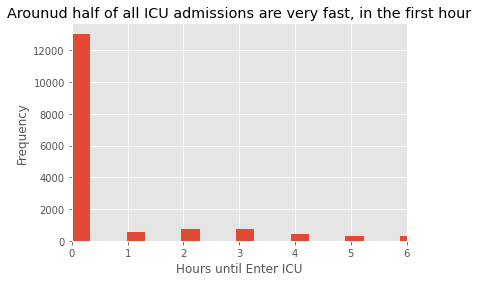

In [ ]:
plt.hist(patient_split['admission_time_until_icu'].astype('timedelta64[h]'), 10000)
plt.xlim(0, 6)
plt.xlabel('Hours until Enter ICU')
plt.ylabel('Frequency')
plt.title('Arounud half of all ICU admissions are very fast, in the first hour')
plt.grid(True)

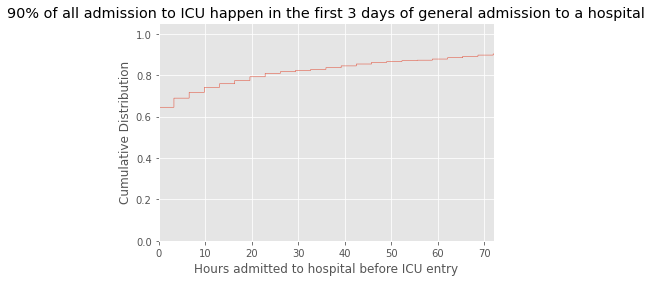

In [ ]:
plt.hist(patient_split['admission_time_until_icu'].dropna().astype('timedelta64[h]') , bins = 1000, cumulative=True, density=True, histtype='step',
                            label='Empirical')
plt.xlim(0, 72)
plt.xlabel('Hours admitted to hospital before ICU entry')
plt.ylabel('Cumulative Distribution')
plt.title('90% of all admission to ICU happen in the first 3 days of general admission to a hospital')
plt.grid(True)

plt.show()

# entire_mimiciii_clinical_icustays_table Features:
1. dbsource
2. first_careunit

In [ ]:
icustays = pd.read_csv('entire_mimic_iii_exported_tables/entire_mimiciii_clinical_icustays_table.csv',
                parse_dates = ['INTIME', 'OUTTIME']
                 )

In [ ]:
icustays.dtypes

ROW_ID                     int64
SUBJECT_ID                 int64
HADM_ID                    int64
ICUSTAY_ID                 int64
DBSOURCE                  object
FIRST_CAREUNIT            object
LAST_CAREUNIT             object
FIRST_WARDID               int64
LAST_WARDID                int64
INTIME            datetime64[ns]
OUTTIME           datetime64[ns]
LOS                      float64
dtype: object

In [ ]:
icustays.isnull().sum()

ROW_ID             0
SUBJECT_ID         0
HADM_ID            0
ICUSTAY_ID         0
DBSOURCE           0
FIRST_CAREUNIT     0
LAST_CAREUNIT      0
FIRST_WARDID       0
LAST_WARDID        0
INTIME             0
OUTTIME           10
LOS               10
dtype: int64

In [ ]:
icustays = icustays[['ICUSTAY_ID','DBSOURCE','FIRST_CAREUNIT','INTIME','OUTTIME']]
icustays = icustays.rename(columns = {'ICUSTAY_ID': 'icustay_id', 'DBSOURCE': 'dbsource', 'FIRST_CAREUNIT': 'first_careunit'})
icustays.head(1)

,icustay_id,dbsource,first_careunit,INTIME,OUTTIME
0,219649,carevue,CCU,2170-10-07 11:28:53,2170-10-14 14:38:07


In [ ]:
patient_split = patient_split.merge(icustays, on = 'icustay_id', how = 'left')

In [ ]:
patient_split.head()

,subject_id,hadm_id,icustay_id,time_of_death,time_until_death,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,admittime,intime,gender,icu_admit_age,admission_time_until_icu,hours_until_icu_admission,dbsource,first_careunit,INTIME,OUTTIME
0,87995,160147,262215,2195-10-08,20 days 09:46:34,1,0,0,2195-09-17 14:12:00,2195-09-17 14:13:26,M,64,0 days 00:01:26,0.0,metavision,MICU,2195-09-17 14:13:26,2195-09-19 21:03:01
1,28546,100408,213952,NaT,NaT,0,0,0,2124-07-03 14:00:00,2124-07-04 09:58:57,M,70,0 days 19:58:57,19.0,carevue,CSRU,2124-07-04 09:58:57,2124-07-05 13:10:44
2,86648,121994,249762,NaT,NaT,0,0,0,2187-04-02 14:16:00,2187-04-02 16:24:18,F,81,0 days 02:08:18,2.0,metavision,MICU,2187-04-02 16:24:18,2187-04-07 15:57:08
3,52087,129686,214231,NaT,NaT,0,0,0,2154-12-11 13:40:00,2154-12-12 14:57:02,M,76,1 days 01:17:02,25.0,metavision,MICU,2154-12-12 14:57:02,2154-12-13 15:32:37
4,77625,181740,205631,NaT,NaT,0,0,0,2201-03-04 09:30:00,2201-03-04 17:22:30,M,51,0 days 07:52:30,7.0,metavision,TSICU,2201-03-04 17:22:30,2201-03-06 21:28:42


In [ ]:
patient_split.groupby(by='dbsource').count()['subject_id']

dbsource
both             49
carevue       13672
metavision     9671
Name: subject_id, dtype: int64

In [ ]:
patient_split.groupby(by='first_careunit').count()['subject_id']
# SICU is Surgical Intensive Care Unit, TSICU is Trauma Surgical Intensive Care Unit, ect

first_careunit
CCU      3414
CSRU     4852
MICU     8118
SICU     3832
TSICU    3176
Name: subject_id, dtype: int64

# mimiciii_clinical.admissions_table Features:
1. ADMISSION_TYPE
2. DIAGNOSIS

In [ ]:
admissions = pd.read_csv('entire_mimic_iii_exported_tables/entire_mimiciii_clinical.admissions_table.csv',
                #parse_dates = ['INTIME', 'OUTTIME']
                 )

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
admissions.dtypes

ROW_ID                   int64
SUBJECT_ID               int64
HADM_ID                  int64
ADMITTIME               object
DISCHTIME               object
DEATHTIME               object
ADMISSION_TYPE          object
ADMISSION_LOCATION      object
DISCHARGE_LOCATION      object
INSURANCE               object
LANGUAGE                object
RELIGION                object
MARITAL_STATUS          object
ETHNICITY               object
EDREGTIME               object
EDOUTTIME               object
DIAGNOSIS               object
HOSPITAL_EXPIRE_FLAG     int64
HAS_CHARTEVENTS_DATA     int64
dtype: object

In [ ]:
admissions[['HADM_ID','ADMISSION_TYPE','DIAGNOSIS']].head(1)

,HADM_ID,ADMISSION_TYPE,DIAGNOSIS
0,136809,EMERGENCY,ALTERED MENTAL STATUS; DYSPNEA


In [ ]:
admissions.groupby(by='ADMISSION_TYPE')['ROW_ID'].count()

# The first care unit is more granular, and very correlated with admission type

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
Name: ROW_ID, dtype: int64

In [ ]:
admissions = admissions[['HADM_ID','ADMISSION_TYPE']].join(pd.get_dummies(admissions["ADMISSION_TYPE"], drop_first = True)) \
  .rename(columns= {'HADM_ID': 'hadm_id', 'ADMISSION_TYPE': 'admission_type'}) \
  .drop(['admission_type','NEWBORN'], axis = 1)

In [ ]:
print(len(patient_split))
patient_split = patient_split.merge(admissions, on = 'hadm_id', how = 'inner')
print(len(patient_split))

23392
23392


# Feature Selection
### Transform Features to Numeric prior to analysis

In [ ]:
patient_split.dtypes

subject_id                             int64
hadm_id                                int64
icustay_id                             int64
time_of_death                 datetime64[ns]
time_until_death             timedelta64[ns]
anytime_expire_flag                    int64
hospital_expire_flag                   int64
icu_expire_flag                        int64
admittime                     datetime64[ns]
intime                        datetime64[ns]
gender                                object
icu_admit_age                          int64
admission_time_until_icu     timedelta64[ns]
hours_until_icu_admission            float64
dbsource                              object
first_careunit                        object
INTIME                        datetime64[ns]
OUTTIME                       datetime64[ns]
EMERGENCY                              uint8
URGENT                                 uint8
dtype: object

In [ ]:
# Time until death -> Hours until death

patient_split['hours_until_death'] = patient_split['time_until_death'].astype('timedelta64[h]')

patient_split['days_until_death'] = patient_split['time_until_death'].astype('timedelta64[D]')

In [ ]:
# Gender -> female boolean

patient_split['female'] = np.where(patient_split['gender']== 'F', 1, 0)
patient_split = patient_split.drop(['gender'], axis = 1)

In [ ]:
# first_careunit -> dummy variables (CCU	CSRU	MICU	SICU	TSICU)
patient_split = patient_split.join(pd.get_dummies(patient_split["first_careunit"], drop_first = True))
patient_split = patient_split.drop(['first_careunit'], axis = 1)
# http://data.patientcarelink.org/staffing/acronyms.cfm

## Set values for Living Patients

In [ ]:
# Hours until Death

max_time_until_death = patient_split['hours_until_death'].max()
mask = patient_split['hours_until_death'].isnull()
mask

0        False
1         True
2         True
3         True
4         True
         ...  
23387    False
23388    False
23389     True
23390     True
23391    False
Name: hours_until_death, Length: 23392, dtype: bool

In [ ]:
max_time_until_death

103018.0

In [ ]:
index_hours_until_death = patient_split.columns.tolist().index('hours_until_death')

In [ ]:
patient_split.iloc[mask[mask].index, index_hours_until_death]= max_time_until_death

# Merge in Validation Diagnosis

In [ ]:
diagnosis = pd.read_csv('static_' + populate_type + '_data_diag.csv',
                  parse_dates = ['dischtime']
                        )
print(diagnosis.dtypes[-21:])

subject_id_y               int64
diagnosis                 object
admission_type            object
dischtime         datetime64[ns]
cardio                     int64
infection                  int64
brain                      int64
mental                     int64
gastro                     int64
trauma                     int64
respiratory                int64
organ                      int64
blood                      int64
acute                      int64
failure                    int64
cancer                     int64
back                       int64
bone                       int64
pain                       int64
other                      int64
totalcats                  int64
dtype: object


In [ ]:
diagnosis = diagnosis.iloc[:,-21:].rename(columns={'subject_id_y':'subject_id'})

In [ ]:
patient_split = patient_split.merge(diagnosis, on = 'subject_id', how = 'inner')

In [ ]:
print(len(patient_split))

23392


# Calculate Length of Time in ICU

In [ ]:
patient_split

,subject_id,hadm_id,icustay_id,time_of_death,time_until_death,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,admittime,intime,icu_admit_age,admission_time_until_icu,hours_until_icu_admission,dbsource,INTIME,OUTTIME,EMERGENCY,URGENT,hours_until_death,days_until_death,female,CSRU,MICU,SICU,TSICU,diagnosis,admission_type,dischtime,cardio,infection,brain,mental,gastro,trauma,respiratory,organ,blood,acute,failure,cancer,back,bone,pain,other,totalcats
0,87995,160147,262215,2195-10-08 00:00:00,20 days 09:46:34,1,0,0,2195-09-17 14:12:00,2195-09-17 14:13:26,64,0 days 00:01:26,0.0,metavision,2195-09-17 14:13:26,2195-09-19 21:03:01,1,0,489.0,20.0,0,0,1,0,0,LOWER GI BLEED,EMERGENCY,2195-09-19 21:02:00,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2
1,28546,100408,213952,NaT,NaT,0,0,0,2124-07-03 14:00:00,2124-07-04 09:58:57,70,0 days 19:58:57,19.0,carevue,2124-07-04 09:58:57,2124-07-05 13:10:44,0,0,103018.0,NaN,0,1,0,0,0,MITRAL STENOSIS MITRAL VALVE REPLACEMENT,ELECTIVE,2124-07-08 12:30:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,86648,121994,249762,NaT,NaT,0,0,0,2187-04-02 14:16:00,2187-04-02 16:24:18,81,0 days 02:08:18,2.0,metavision,2187-04-02 16:24:18,2187-04-07 15:57:08,1,0,103018.0,NaN,1,0,1,0,0,PNEUMONIA,EMERGENCY,2187-04-19 16:26:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,52087,129686,214231,NaT,NaT,0,0,0,2154-12-11 13:40:00,2154-12-12 14:57:02,76,1 days 01:17:02,25.0,metavision,2154-12-12 14:57:02,2154-12-13 15:32:37,1,0,103018.0,NaN,0,0,1,0,0,LOWER GI BLEED,EMERGENCY,2154-12-18 13:18:00,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2
4,77625,181740,205631,NaT,NaT,0,0,0,2201-03-04 09:30:00,2201-03-04 17:22:30,51,0 days 07:52:30,7.0,metavision,2201-03-04 17:22:30,2201-03-06 21:28:42,0,0,103018.0,NaN,0,0,0,0,1,TREACHEAL STENOSIS SDA,ELECTIVE,2201-03-12 15:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23387,10784,150384,253447,2145-09-13 05:15:00,6 days 15:10:25,1,1,1,2145-09-06 14:03:00,2145-09-06 14:04:35,77,0 days 00:01:35,0.0,carevue,2145-09-06 14:04:35,2145-09-13 06:55:45,1,0,159.0,6.0,1,0,0,0,1,POLYTRAUMA S P MVC,EMERGENCY,2145-09-13 05:15:00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
23388,80518,140505,209138,2150-09-03 10:05:00,12 days 11:42:49,1,1,1,2150-08-21 22:21:00,2150-08-21 22:22:11,82,0 days 00:01:11,0.0,metavision,2150-08-21 22:22:11,2150-09-03 17:33:56,1,0,299.0,12.0,1,0,1,0,0,ADULT RESPIRATORY DISTRESS SYNDROME CHRONIC OB...,EMERGENCY,2150-09-03 10:05:00,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2
23389,26059,188586,218045,NaT,NaT,0,0,0,2125-12-19 17:11:00,2125-12-19 17:12:51,35,0 days 00:01:51,0.0,carevue,2125-12-19 17:12:51,2125-12-20 18:29:20,1,0,103018.0,NaN,0,0,1,0,0,ETOH WITHDRAWAL,EMERGENCY,2125-12-21 17:54:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
23390,23626,166653,230856,NaT,NaT,0,0,0,2186-09-12 09:22:00,2186-09-12 09:24:26,61,0 days 00:02:26,0.0,carevue,2186-09-12 09:24:26,2186-09-25 09:02:08,1,0,103018.0,NaN,0,0,0,0,0,VENTRICULAR ARREST,EMERGENCY,2186-09-25 09:05:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
patient_split['time_until_leave_ICU']  = patient_split['OUTTIME'] - patient_split['INTIME']

In [ ]:
patient_split['time_until_leave_ICU'].describe()

# What is the average time until an ICU patient leaves the hospital?
# Maybe predicting ICU patients and when they would leave ICU, can use patients that survive to get larger sample, but figure out factoring patients who die... (NEED TO EXCLUDE WITH MODEL..)

count                        23391
mean     4 days 02:21:25.350348423
std      6 days 02:34:29.167296634
min                0 days 00:00:12
25%                1 days 04:34:15
50%                2 days 02:17:56
75%         4 days 02:30:27.500000
max              153 days 22:16:17
Name: time_until_leave_ICU, dtype: object

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


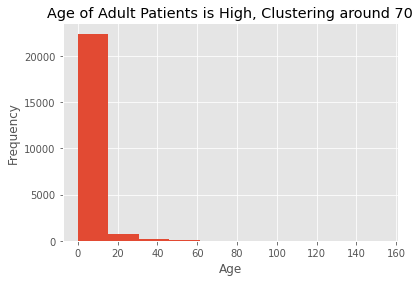

In [ ]:
plt.hist(patient_split['time_until_leave_ICU'].astype('timedelta64[D]'), 10)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age of Adult Patients is High, Clustering around 70')
plt.grid(True)

plt.show()

# Correlation Results

In [ ]:
patient_split.describe()

,subject_id,hadm_id,icustay_id,time_until_death,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,icu_admit_age,admission_time_until_icu,hours_until_icu_admission,EMERGENCY,URGENT,hours_until_death,days_until_death,female,CSRU,MICU,SICU,TSICU,cardio,infection,brain,mental,gastro,trauma,respiratory,organ,blood,acute,failure,cancer,back,bone,pain,other,totalcats,time_until_leave_ICU
count,23392.000000,23392.000000,23392.000000,9153,23392.000000,23392.000000,23392.000000,23392.000000,23392,23392.000000,23392.000000,23392.000000,23392.000000,9153.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23392.000000,23391
mean,38101.250641,150214.857986,250410.097213,585 days 13:24:40.030809568,0.391288,0.107045,0.077291,62.367391,1 days 01:33:40.152573529,25.317886,0.806814,0.031378,68207.063483,585.132634,0.423051,0.207421,0.347042,0.163817,0.135773,0.323914,0.093451,0.088620,0.036038,0.110722,0.097042,0.092852,0.063996,0.131113,0.036636,0.056686,0.019323,0.010602,0.010388,0.050958,0.143682,1.222341,4 days 02:21:25.350348423
std,29309.326857,28840.333814,28938.196866,832 days 04:35:29.154736784,0.488049,0.309177,0.267059,16.882629,3 days 09:45:48.382146750,81.685877,0.394806,0.174341,45180.894899,832.200945,0.494054,0.405469,0.476039,0.370117,0.342555,0.467978,0.291069,0.284201,0.186389,0.313794,0.296021,0.290231,0.244751,0.337531,0.187872,0.231247,0.137660,0.102421,0.101394,0.219916,0.350774,0.777791,6 days 02:34:29.167296634
min,3.000000,100007.000000,200003.000000,0 days 00:04:35,0.000000,0.000000,0.000000,15.000000,0 days 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:12
25%,14001.000000,125283.750000,225354.750000,13 days 18:58:51,0.000000,0.000000,0.000000,52.000000,0 days 00:01:16,0.000000,1.000000,0.000000,10881.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1 days 04:34:15
50%,27744.000000,150486.500000,250477.000000,161 days 22:06:34,0.000000,0.000000,0.000000,64.000000,0 days 00:02:32,0.000000,1.000000,0.000000,103018.000000,161.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2 days 02:17:56
75%,62597.000000,175256.750000,275597.500000,870 days 01:57:16,1.000000,0.000000,0.000000,76.000000,0 days 15:25:00.500000,15.000000,1.000000,0.000000,103018.000000,870.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4 days 02:30:27.500000
max,99995.000000,199999.000000,299999.000000,4292 days 10:57:00,1.000000,1.000000,1.000000,89.000000,136 days 05:06:00,3269.000000,1.000000,1.000000,103018.000000,4292.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,153 days 22:16:17


In [ ]:
patient_split.head(5) # Fields of time_of_death, admittime, intime, gender, first_careunit, hours_until_death

,subject_id,hadm_id,icustay_id,time_of_death,time_until_death,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,admittime,intime,icu_admit_age,admission_time_until_icu,hours_until_icu_admission,dbsource,INTIME,OUTTIME,EMERGENCY,URGENT,hours_until_death,days_until_death,female,CSRU,MICU,SICU,TSICU,diagnosis,admission_type,dischtime,cardio,infection,brain,mental,gastro,trauma,respiratory,organ,blood,acute,failure,cancer,back,bone,pain,other,totalcats,time_until_leave_ICU
0,87995,160147,262215,2195-10-08,20 days 09:46:34,1,0,0,2195-09-17 14:12:00,2195-09-17 14:13:26,64,0 days 00:01:26,0.0,metavision,2195-09-17 14:13:26,2195-09-19 21:03:01,1,0,489.0,20.0,0,0,1,0,0,LOWER GI BLEED,EMERGENCY,2195-09-19 21:02:00,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,2 days 06:49:35
1,28546,100408,213952,NaT,NaT,0,0,0,2124-07-03 14:00:00,2124-07-04 09:58:57,70,0 days 19:58:57,19.0,carevue,2124-07-04 09:58:57,2124-07-05 13:10:44,0,0,103018.0,NaN,0,1,0,0,0,MITRAL STENOSIS MITRAL VALVE REPLACEMENT,ELECTIVE,2124-07-08 12:30:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1 days 03:11:47
2,86648,121994,249762,NaT,NaT,0,0,0,2187-04-02 14:16:00,2187-04-02 16:24:18,81,0 days 02:08:18,2.0,metavision,2187-04-02 16:24:18,2187-04-07 15:57:08,1,0,103018.0,NaN,1,0,1,0,0,PNEUMONIA,EMERGENCY,2187-04-19 16:26:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4 days 23:32:50
3,52087,129686,214231,NaT,NaT,0,0,0,2154-12-11 13:40:00,2154-12-12 14:57:02,76,1 days 01:17:02,25.0,metavision,2154-12-12 14:57:02,2154-12-13 15:32:37,1,0,103018.0,NaN,0,0,1,0,0,LOWER GI BLEED,EMERGENCY,2154-12-18 13:18:00,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,1 days 00:35:35
4,77625,181740,205631,NaT,NaT,0,0,0,2201-03-04 09:30:00,2201-03-04 17:22:30,51,0 days 07:52:30,7.0,metavision,2201-03-04 17:22:30,2201-03-06 21:28:42,0,0,103018.0,NaN,0,0,0,0,1,TREACHEAL STENOSIS SDA,ELECTIVE,2201-03-12 15:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2 days 04:06:12


In [ ]:
patient_split.corr()['hours_until_death']

subject_id                   0.140661
hadm_id                      0.008065
icustay_id                  -0.006439
anytime_expire_flag         -0.961011
hospital_expire_flag        -0.521157
icu_expire_flag             -0.436004
icu_admit_age               -0.313258
hours_until_icu_admission   -0.091881
EMERGENCY                   -0.121793
URGENT                      -0.019223
hours_until_death            1.000000
days_until_death             1.000000
female                      -0.034642
CSRU                         0.174105
MICU                        -0.145829
SICU                        -0.030860
TSICU                        0.064781
cardio                       0.096842
infection                   -0.105883
brain                       -0.023811
mental                       0.024497
gastro                       0.000044
trauma                       0.069609
respiratory                 -0.042364
organ                       -0.045260
blood                       -0.051741
acute       

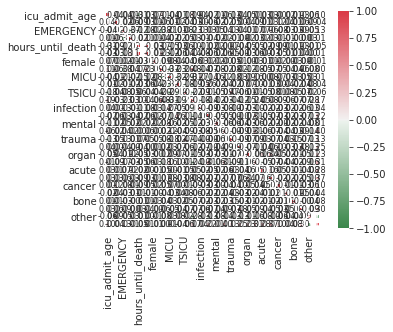

In [ ]:
# Correlations of a little less than 1% to hours until death


import seaborn as sns
cmap = sns.diverging_palette(h_neg=133, h_pos = 10, as_cmap=True)
#data = data.style.background_gradient(cmap=cmap)
#['days_until_death']
#patient_split.corr().iloc[6:,6:].style.background_gradient(cmap=cmap)
plt.style.use('ggplot')
# https://stackoverflow.com/questions/50682797/seaborn-diverging-palette-with-more-than-2-color-tones
with sns.axes_style("white"):
    ax = sns.heatmap(patient_split.corr().iloc[6:,6:], annot=True
                     , fmt='.2f'
    , cmap=cmap
                    , vmin=-1
                     #, vmax=.99
                     , center=0.00
                ,square=True
                , linewidths= 4
                , annot_kws={"size": 8}
                #, cbar_kws={"shrink": .5}
                )
plt.show()

# The collinearity between the related features is around 40% maxinum, so that isn't high enough to cause issues in convergences. If we have issues in convergence, or non-sensical coefficients then features can be removed.
# CSRU: Adult Critical Care - Cardiothoracic
# MICU: Medical Intensive Care Unit

# Can see how there is overlap between the two ICU admission fields, so the less granular of Elective, Emergency, Newborn, Urgent can dropped

In [ ]:
# data.style.background_gradient(cmap=cmap)
#cmap = sns.converging_palette(h_neg=133, h_pos = 10, as_cmap=True)
 # data = data.style.background_gradient(cmap=cmap)
# patient_split.corr().iloc[6:,6:].style.background_gradient(cmap=cmap)
cm = sns.light_palette('green', as_cmap=True)

s = patient_split.corr().iloc[6:,6:].abs().style.background_gradient(cmap=cm, axis=0)
s

,icu_admit_age,hours_until_icu_admission,EMERGENCY,URGENT,hours_until_death,days_until_death,female,CSRU,MICU,SICU,TSICU,cardio,infection,brain,mental,gastro,trauma,respiratory,organ,blood,acute,failure,cancer,back,bone,pain,other,totalcats
icu_admit_age,1.000000,0.038193,0.037302,0.014675,0.313258,0.025400,0.069596,0.113530,0.041175,0.010939,0.178620,0.193925,0.037017,0.022094,0.111537,0.062844,0.127811,0.042936,0.045886,0.011270,0.025221,0.034930,0.000054,0.016494,0.007486,0.029582,0.062379,0.102569
hours_until_icu_admission,0.038193,1.000000,0.022872,0.055460,0.091881,0.029848,0.008572,0.057109,0.009771,0.024932,0.044633,0.032027,0.004612,0.057047,0.018066,0.017870,0.054782,0.000223,0.037697,0.086187,0.006760,0.030998,0.119969,0.042378,0.007416,0.057723,0.090791,0.041283
EMERGENCY,0.037302,0.022872,1.000000,0.367821,0.121793,0.180991,0.023181,0.375665,0.209109,0.009571,0.075410,0.226352,0.131066,0.034853,0.053946,0.040841,0.128957,0.038280,0.008761,0.169871,0.066030,0.062824,0.084702,0.031813,0.029963,0.088275,0.046214,0.125822
URGENT,0.014675,0.055460,0.367821,1.000000,0.019223,0.113189,0.007187,0.036137,0.018920,0.020036,0.052012,0.033665,0.014821,0.040594,0.016382,0.022452,0.008473,0.003509,0.023071,0.027779,0.024942,0.029047,0.008581,0.011449,0.001511,0.003794,0.029737,0.009080
hours_until_death,0.313258,0.091881,0.121793,0.019223,1.000000,1.000000,0.034642,0.174105,0.145829,0.030860,0.064781,0.096842,0.105883,0.023811,0.024497,0.000044,0.069609,0.042364,0.045260,0.051741,0.020478,0.091011,0.085905,0.007552,0.005556,0.028726,0.008496,0.048996
days_until_death,0.025400,0.029848,0.180991,0.113189,1.000000,1.000000,0.010275,0.227824,0.123231,0.064422,0.044856,0.142690,0.082449,0.064504,0.016147,0.056096,0.049619,0.004590,0.033615,0.058122,0.004783,0.026297,0.053026,0.014466,0.005662,0.039215,0.004777,0.007806
female,0.069596,0.008572,0.023181,0.007187,0.034642,0.010275,1.000000,0.089557,0.077377,0.044157,0.041834,0.057405,0.026522,0.023449,0.021527,0.004770,0.045112,0.008686,0.002937,0.029099,0.012231,0.008245,0.024378,0.000774,0.026626,0.004044,0.012119,0.005150
CSRU,0.113530,0.057109,0.375665,0.036137,0.174105,0.227824,0.089557,1.000000,0.372953,0.226430,0.202767,0.484036,0.142876,0.072709,0.084771,0.019899,0.082936,0.017976,0.116103,0.183416,0.050936,0.068411,0.053427,0.042661,0.042015,0.055018,0.079698,0.004230
MICU,0.041175,0.009771,0.209109,0.018920,0.145829,0.123231,0.077377,0.372953,1.000000,0.322683,0.288962,0.309451,0.270395,0.139803,0.159698,0.122252,0.183176,0.028847,0.094110,0.155816,0.001236,0.076438,0.071851,0.030748,0.028936,0.053771,0.030363,0.010049
SICU,0.010939,0.024932,0.009571,0.020036,0.030860,0.064422,0.044157,0.226430,0.322683,1.000000,0.175437,0.189126,0.051630,0.257437,0.017412,0.037651,0.022969,0.066388,0.072569,0.100465,0.011307,0.030080,0.004997,0.044405,0.019147,0.037959,0.078508,0.043663


In [ ]:
#cm = sns.light_palette('green', as_cmap=True)
cm = sns.diverging_palette(h_neg=133, h_pos = 10, as_cmap=True)

s = patient_split.corr().iloc[6:,6:].style.background_gradient(cmap=cm, axis=0, vmin=-1)
s

,icu_admit_age,hours_until_icu_admission,EMERGENCY,URGENT,hours_until_death,days_until_death,female,CSRU,MICU,SICU,TSICU,cardio,infection,brain,mental,gastro,trauma,respiratory,organ,blood,acute,failure,cancer,back,bone,pain,other,totalcats
icu_admit_age,1.000000,0.038193,-0.037302,0.014675,-0.313258,-0.025400,0.069596,0.113530,-0.041175,-0.010939,-0.178620,0.193925,0.037017,-0.022094,-0.111537,0.062844,-0.127811,0.042936,-0.045886,0.011270,0.025221,0.034930,0.000054,-0.016494,0.007486,0.029582,-0.062379,0.102569
hours_until_icu_admission,0.038193,1.000000,-0.022872,0.055460,-0.091881,-0.029848,0.008572,0.057109,-0.009771,0.024932,-0.044633,-0.032027,0.004612,-0.057047,-0.018066,-0.017870,-0.054782,0.000223,0.037697,-0.086187,0.006760,0.030998,0.119969,0.042378,0.007416,0.057723,0.090791,-0.041283
EMERGENCY,-0.037302,-0.022872,1.000000,-0.367821,-0.121793,-0.180991,0.023181,-0.375665,0.209109,-0.009571,0.075410,-0.226352,0.131066,0.034853,0.053946,0.040841,0.128957,0.038280,-0.008761,0.169871,0.066030,0.062824,-0.084702,-0.031813,-0.029963,0.088275,-0.046214,0.125822
URGENT,0.014675,0.055460,-0.367821,1.000000,-0.019223,0.113189,0.007187,0.036137,-0.018920,-0.020036,-0.052012,0.033665,-0.014821,-0.040594,-0.016382,0.022452,-0.008473,-0.003509,0.023071,-0.027779,0.024942,0.029047,0.008581,-0.011449,-0.001511,-0.003794,0.029737,0.009080
hours_until_death,-0.313258,-0.091881,-0.121793,-0.019223,1.000000,1.000000,-0.034642,0.174105,-0.145829,-0.030860,0.064781,0.096842,-0.105883,-0.023811,0.024497,0.000044,0.069609,-0.042364,-0.045260,-0.051741,-0.020478,-0.091011,-0.085905,0.007552,-0.005556,0.028726,-0.008496,-0.048996
days_until_death,-0.025400,-0.029848,-0.180991,0.113189,1.000000,1.000000,-0.010275,0.227824,-0.123231,-0.064422,-0.044856,0.142690,-0.082449,-0.064504,-0.016147,0.056096,0.049619,-0.004590,-0.033615,-0.058122,0.004783,-0.026297,-0.053026,-0.014466,0.005662,0.039215,0.004777,0.007806
female,0.069596,0.008572,0.023181,0.007187,-0.034642,-0.010275,1.000000,-0.089557,0.077377,0.044157,-0.041834,-0.057405,0.026522,0.023449,0.021527,0.004770,-0.045112,0.008686,-0.002937,0.029099,-0.012231,0.008245,0.024378,-0.000774,0.026626,-0.004044,0.012119,-0.005150
CSRU,0.113530,0.057109,-0.375665,0.036137,0.174105,0.227824,-0.089557,1.000000,-0.372953,-0.226430,-0.202767,0.484036,-0.142876,-0.072709,-0.084771,-0.019899,-0.082936,0.017976,-0.116103,-0.183416,-0.050936,-0.068411,-0.053427,-0.042661,-0.042015,0.055018,-0.079698,0.004230
MICU,-0.041175,-0.009771,0.209109,-0.018920,-0.145829,-0.123231,0.077377,-0.372953,1.000000,-0.322683,-0.288962,-0.309451,0.270395,-0.139803,0.159698,0.122252,-0.183176,0.028847,0.094110,0.155816,0.001236,0.076438,0.071851,-0.030748,0.028936,-0.053771,0.030363,0.010049
SICU,-0.010939,0.024932,-0.009571,-0.020036,-0.030860,-0.064422,0.044157,-0.226430,-0.322683,1.000000,-0.175437,-0.189126,-0.051630,0.257437,-0.017412,-0.037651,-0.022969,-0.066388,0.072569,0.100465,-0.011307,-0.030080,0.004997,0.044405,-0.019147,-0.037959,0.078508,-0.043663


In [ ]:
if drop_unused_features:
    patient_split = patient_split.drop([
                                        'hours_until_death'
                                        , 'admission_time_until_icu' # Converted to hours
                                        ], axis =1)

# Export Train, Validation and Test Set

In [ ]:
len(patient_split)

23392

# Export

In [ ]:
if proceed_export:
    patient_split.to_csv('static_' + populate_type + '_data.csv')
    print('Exported data of', populate_type)
else:
    print('Not exported, existing files were used instead')

Not exported, existing files were used instead


In [ ]:
patient_split

,subject_id,hadm_id,icustay_id,time_of_death,time_until_death,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,admittime,intime,icu_admit_age,hours_until_icu_admission,dbsource,INTIME,OUTTIME,EMERGENCY,URGENT,days_until_death,female,CSRU,MICU,SICU,TSICU,diagnosis,admission_type,dischtime,cardio,infection,brain,mental,gastro,trauma,respiratory,organ,blood,acute,failure,cancer,back,bone,pain,other,totalcats,time_until_leave_ICU
0,87995,160147,262215,2195-10-08 00:00:00,20 days 09:46:34,1,0,0,2195-09-17 14:12:00,2195-09-17 14:13:26,64,0.0,metavision,2195-09-17 14:13:26,2195-09-19 21:03:01,1,0,20.0,0,0,1,0,0,LOWER GI BLEED,EMERGENCY,2195-09-19 21:02:00,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,2 days 06:49:35
1,28546,100408,213952,NaT,NaT,0,0,0,2124-07-03 14:00:00,2124-07-04 09:58:57,70,19.0,carevue,2124-07-04 09:58:57,2124-07-05 13:10:44,0,0,NaN,0,1,0,0,0,MITRAL STENOSIS MITRAL VALVE REPLACEMENT,ELECTIVE,2124-07-08 12:30:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1 days 03:11:47
2,86648,121994,249762,NaT,NaT,0,0,0,2187-04-02 14:16:00,2187-04-02 16:24:18,81,2.0,metavision,2187-04-02 16:24:18,2187-04-07 15:57:08,1,0,NaN,1,0,1,0,0,PNEUMONIA,EMERGENCY,2187-04-19 16:26:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4 days 23:32:50
3,52087,129686,214231,NaT,NaT,0,0,0,2154-12-11 13:40:00,2154-12-12 14:57:02,76,25.0,metavision,2154-12-12 14:57:02,2154-12-13 15:32:37,1,0,NaN,0,0,1,0,0,LOWER GI BLEED,EMERGENCY,2154-12-18 13:18:00,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,1 days 00:35:35
4,77625,181740,205631,NaT,NaT,0,0,0,2201-03-04 09:30:00,2201-03-04 17:22:30,51,7.0,metavision,2201-03-04 17:22:30,2201-03-06 21:28:42,0,0,NaN,0,0,0,0,1,TREACHEAL STENOSIS SDA,ELECTIVE,2201-03-12 15:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2 days 04:06:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23387,10784,150384,253447,2145-09-13 05:15:00,6 days 15:10:25,1,1,1,2145-09-06 14:03:00,2145-09-06 14:04:35,77,0.0,carevue,2145-09-06 14:04:35,2145-09-13 06:55:45,1,0,6.0,1,0,0,0,1,POLYTRAUMA S P MVC,EMERGENCY,2145-09-13 05:15:00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,6 days 16:51:10
23388,80518,140505,209138,2150-09-03 10:05:00,12 days 11:42:49,1,1,1,2150-08-21 22:21:00,2150-08-21 22:22:11,82,0.0,metavision,2150-08-21 22:22:11,2150-09-03 17:33:56,1,0,12.0,1,0,1,0,0,ADULT RESPIRATORY DISTRESS SYNDROME CHRONIC OB...,EMERGENCY,2150-09-03 10:05:00,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,12 days 19:11:45
23389,26059,188586,218045,NaT,NaT,0,0,0,2125-12-19 17:11:00,2125-12-19 17:12:51,35,0.0,carevue,2125-12-19 17:12:51,2125-12-20 18:29:20,1,0,NaN,0,0,1,0,0,ETOH WITHDRAWAL,EMERGENCY,2125-12-21 17:54:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1 days 01:16:29
23390,23626,166653,230856,NaT,NaT,0,0,0,2186-09-12 09:22:00,2186-09-12 09:24:26,61,0.0,carevue,2186-09-12 09:24:26,2186-09-25 09:02:08,1,0,NaN,0,0,0,0,0,VENTRICULAR ARREST,EMERGENCY,2186-09-25 09:05:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,12 days 23:37:42


# EDA

In [ ]:
patient_split['icu_admit_age'].describe()

count    23392.000000
mean        62.367391
std         16.882629
min         15.000000
25%         52.000000
50%         64.000000
75%         76.000000
max         89.000000
Name: icu_admit_age, dtype: float64

In [ ]:
patient_split['icu_admit_age'].mode()

0    77
dtype: int64

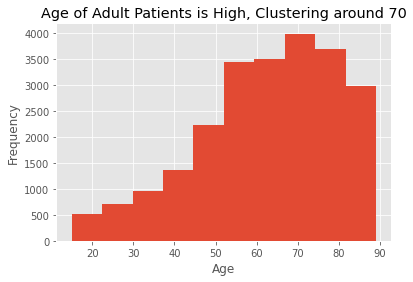

In [ ]:
plt.hist(patient_split['icu_admit_age'], 10)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age of Adult Patients is High, Clustering around 70')
plt.grid(True)

plt.show()

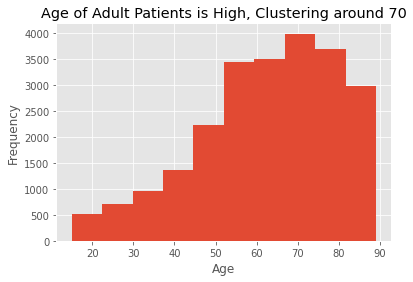

In [ ]:
#fig=plt.figure()
#plt.style.use('dark_background')
#plt.rcParams['axes.facecolor'] = 'g'
#plt.rcParams['savefig.facecolor'] = 'b'


plt.hist(patient_split['icu_admit_age'], 10)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age of Adult Patients is High, Clustering around 70')
plt.grid(True)

plt.show()

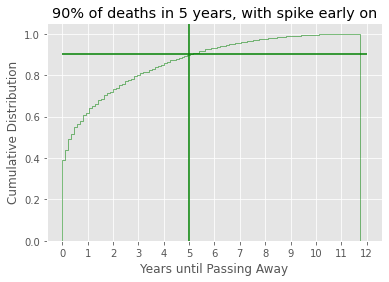

In [ ]:
plt.hist(patient_split['time_until_death'].dropna().astype('timedelta64[M]') / 12 , bins = 100, density=True, histtype='step',
                           cumulative=True, label='Empirical', color='g')
plt.xlabel('Years until Passing Away')
plt.ylabel('Cumulative Distribution')
plt.title('90% of deaths in 5 years, with spike early on')
plt.axvline(5, color='g')
plt.xticks(np.arange(0, 13, step= 1))
plt.hlines(.90, xmin=0, xmax=12, color='g')
plt.grid(True)

plt.show()

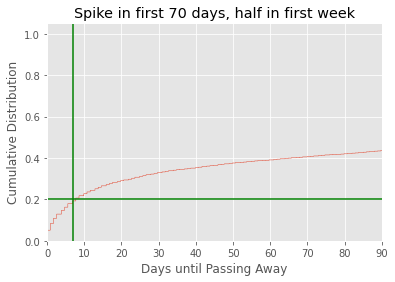

In [ ]:
plt.hist(patient_split['time_until_death'].dropna().astype('timedelta64[D]') , bins = 10000, density=True, histtype='step',
                           cumulative=True, label='Empirical')
plt.xlim(0, 90)
plt.xlabel('Days until Passing Away')
plt.ylabel('Cumulative Distribution')
plt.title('Spike in first 70 days, half in first week')
#plt.xticks(np.arange(0, 13, 1))
plt.axvline(7, color='g')
plt.hlines(.20, xmin=0, xmax=90, color='g')
plt.grid(True)

plt.show()

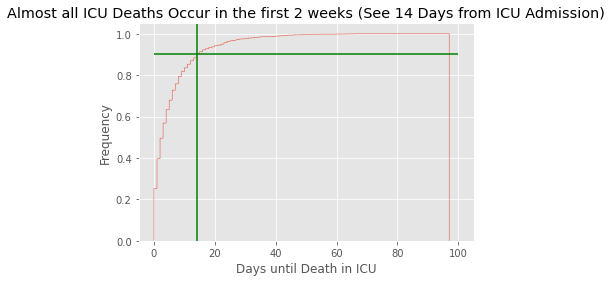

In [ ]:

plt.hist(patient_split[patient_split['icu_expire_flag'] == 1]['time_until_death'].dropna().astype('timedelta64[D]') , bins = 10000, density=True, histtype='step',
                           cumulative=True, label='Empirical')



#plt.hist(patient_split[patient_split['icu_expire_flag'] == 1]['time_until_death'].astype('timedelta64[D]'), 10)
plt.xlabel('Days until Death in ICU')
plt.axvline(14, color='g')
plt.hlines(.90, xmin=0, xmax=100, color='g')
plt.ylabel('Frequency')
plt.title('Almost all ICU Deaths Occur in the first 2 weeks (See 14 Days from ICU Admission)')
plt.grid(True)




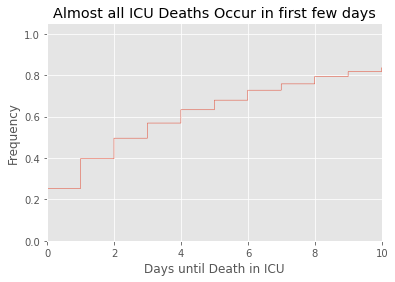

In [ ]:
plt.hist(patient_split[patient_split['icu_expire_flag'] == 1]['time_until_death'].dropna().astype('timedelta64[D]') , bins = 10000, density=True, histtype='step',
                           cumulative=True, label='Empirical')
plt.xlim(0, 10)
plt.xlabel('Days until Death in ICU')
plt.ylabel('Frequency')
plt.title('Almost all ICU Deaths Occur in first few days')
plt.grid(True)


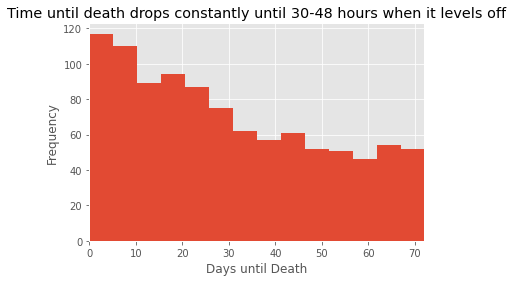

In [ ]:
plt.hist(patient_split[(patient_split['anytime_expire_flag'] == 1)]['time_until_death'].astype('timedelta64[h]'), 20000)
plt.xlim(0, 72)
plt.xlabel('Days until Death')
plt.ylabel('Frequency')
plt.title('Time until death drops constantly until 30-48 hours when it levels off')
plt.grid(True)


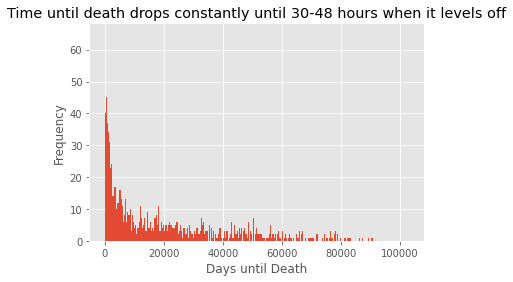

In [ ]:
plt.hist(patient_split[(patient_split['anytime_expire_flag'] == 1) & (patient_split['hospital_expire_flag'] == 0)]['time_until_death'].astype('timedelta64[h]'), 2000)
#plt.xlim(0, 72)
plt.xlabel('Days until Death')
plt.ylabel('Frequency')
plt.title('Time until death drops constantly until 30-48 hours when it levels off')
plt.grid(True)

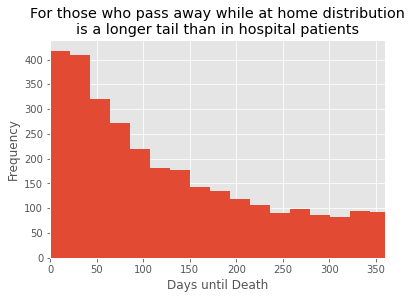

In [ ]:
plt.hist(patient_split[(patient_split['anytime_expire_flag'] == 1) & (patient_split['hospital_expire_flag'] == 0)]['time_until_death'].astype('timedelta64[D]'), 200)
plt.xlim(0, 360)
plt.xlabel('Days until Death')
plt.ylabel('Frequency')
plt.title('For those who pass away while at home distribution\nis a longer tail than in hospital patients')
plt.grid(True)

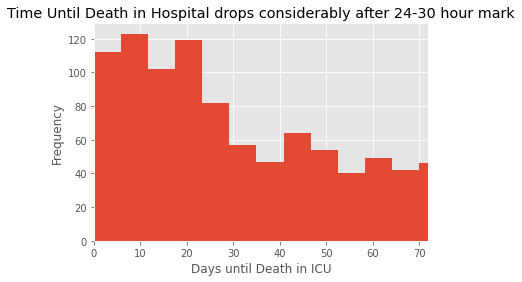

In [ ]:
plt.hist(patient_split[(patient_split['icu_expire_flag'] == 1) & (patient_split['hospital_expire_flag'] == 1)]['time_until_death'].astype('timedelta64[h]'), 400)
plt.xlim(0, 72)
plt.xlabel('Days until Death in ICU')
plt.ylabel('Frequency')
plt.title('Time Until Death in Hospital drops considerably after 24-30 hour mark')
plt.grid(True)


In [ ]:
# data = patient_split[(patient_split['icu_expire_flag'] == 1) & (patient_df['time_until_death'] < pd.Timedelta(48,'h'))]

# data['minutes_until_death'] = data['time_until_death'].astype('timedelta64[m]')

# data

# plt.hist(data['minutes_until_death'] , 10)
# # plt.xlim(0, 24)
# plt.xlabel('Hours')
# plt.ylabel('Cumulative Distribution')
# plt.title('Around 70% of all deaths are before the first year')
# plt.grid(True)

# plt.show()

In [ ]:
patient_split.dtypes

subject_id                             int64
hadm_id                                int64
icustay_id                             int64
time_of_death                 datetime64[ns]
time_until_death             timedelta64[ns]
anytime_expire_flag                    int64
hospital_expire_flag                   int64
icu_expire_flag                        int64
admittime                     datetime64[ns]
intime                        datetime64[ns]
icu_admit_age                          int64
hours_until_icu_admission            float64
dbsource                              object
INTIME                        datetime64[ns]
OUTTIME                       datetime64[ns]
EMERGENCY                              uint8
URGENT                                 uint8
days_until_death                     float64
female                                 int64
CSRU                                   uint8
MICU                                   uint8
SICU                                   uint8
TSICU     